In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/StudyData/temperature.csv')
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           45253 non-null  object 
 1   Vancouver          44458 non-null  float64
 2   Portland           45252 non-null  float64
 3   San Francisco      44460 non-null  float64
 4   Seattle            45250 non-null  float64
 5   Los Angeles        45250 non-null  float64
 6   San Diego          45252 non-null  float64
 7   Las Vegas          45252 non-null  float64
 8   Phoenix            45250 non-null  float64
 9   Albuquerque        45252 non-null  float64
 10  Denver             45252 non-null  float64
 11  San Antonio        45252 non-null  float64
 12  Dallas             45249 non-null  float64
 13  Houston            45250 non-null  float64
 14  Kansas City        45252 non-null  float64
 15  Minneapolis        45240 non-null  float64
 16  Saint Louis        452

In [ ]:
df=df[['datetime','Albuquerque']]

In [ ]:
df.isna().sum()

datetime       0
Albuquerque    1
dtype: int64

In [ ]:
df = df.dropna()

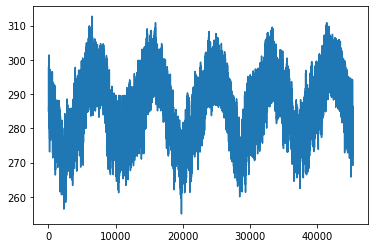

In [ ]:
plt.plot(range(1,len(df['Albuquerque'].values)+1),df['Albuquerque'].values)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data = df['Albuquerque'].values
data = min_max_scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
print(data.shape)
data =data.flatten()
print(data.shape)

(45252, 1)
(45252,)


In [ ]:
window = 15

n_samples=data.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.15*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  31666 Validation =  6786 Test =  6785


In [ ]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [ ]:
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=data[i+j]
  y_train[i]=data[i+window]

for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=data[n_train_samples+i+j]
  y_val[i]=data[n_train_samples+i+window]

for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=data[n_train_samples+n_val_samples+i+j]
  y_test[i]=data[n_train_samples+n_val_samples+i+window]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

ff_model=Sequential()
ff_model.add(Dense(10,activation='relu',input_dim=window))
ff_model.add(Dense(1))

In [ ]:
ff_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                160       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ff_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/StudyData/Models/ff-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [ ]:
ff_model_history = ff_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
1266/1267 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0420
Epoch 1: val_mae improved from inf to 0.02811, saving model to /content/gdrive/My Drive/StudyData/Models/ff-temperature-01-0.028.hdf5
1267/1267 [==============================] - 5s 4ms/step - loss: 0.0033 - mae: 0.0420 - val_loss: 0.0014 - val_mae: 0.0281
Epoch 2/40
1265/1267 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0249
Epoch 2: val_mae improved from 0.02811 to 0.02291, saving model to /content/gdrive/My Drive/StudyData/Models/ff-temperature-02-0.023.hdf5
1267/1267 [==============================] - 3s 3ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 9.8505e-04 - val_mae: 0.0229
Epoch 3/40
1239/1267 [============================>.] - ETA: 0s - loss: 9.7086e-04 - mae: 0.0222
Epoch 3: val_mae improved from 0.02291 to 0.02011, saving model to /content/gdrive/My Drive/StudyData/Models/ff-temperature-03-0.020.hdf5
1267/1267 [==============================] - 3s 2ms/step 

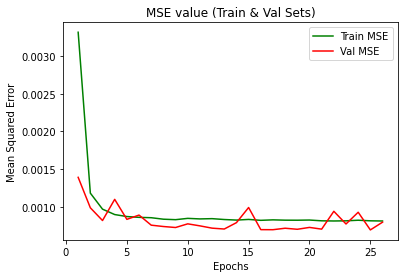

In [ ]:
loss_function = ff_model_history.history['loss']
val_loss_function = ff_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('MSE value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train MSE')
plt.plot(epochs,val_loss_function,color='red',label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
ff_model.load_weights('/content/gdrive/My Drive/StudyData/Models/ff-temperature-18-0.019.hdf5')

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score

y_pred = ff_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

213/213 [==============================] - 0s 1ms/step
MAE =  1.036  K degrees
R2-score =  0.972


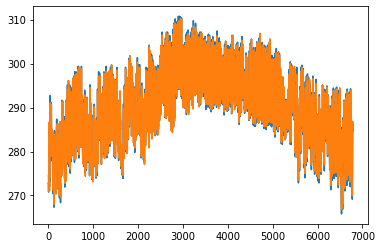

In [ ]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

In [ ]:
from keras.layers import SimpleRNN

simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(10,activation='relu',input_shape=(window,1)))
simple_rnn_model.add(Dense(1,activation='linear'))

In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [ ]:
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [ ]:
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
1264/1267 [============================>.] - ETA: 0s - loss: 0.0936 - mae: 0.1999
Epoch 1: val_mae improved from inf to 0.02683, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-01-0.027.hdf5
1267/1267 [==============================] - 7s 5ms/step - loss: 0.0934 - mae: 0.1995 - val_loss: 0.0015 - val_mae: 0.0268
Epoch 2/40
1260/1267 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0231
Epoch 2: val_mae improved from 0.02683 to 0.02204, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-02-0.022.hdf5
1267/1267 [==============================] - 7s 6ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 9.9039e-04 - val_mae: 0.0220
Epoch 3/40
1255/1267 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0214
Epoch 3: val_mae improved from 0.02204 to 0.02083, saving model to /content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-03-0.021.hdf5
1267/1267 [==========================

In [ ]:
simple_rnn_model.load_weights('/content/gdrive/My Drive/StudyData/Models/simple_rnn-temperature-10-0.019.hdf5')

In [ ]:
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

213/213 [==============================] - 1s 2ms/step
MAE =  1.104  K degrees
R2-score =  0.966


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

model = Sequential()
model.add(LSTM(10,input_shape=(window,1)))
model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='mse',metrics='mae')

In [ ]:
history = model.fit(X_train,y_train,epochs=30,batch_size=32,
                    validation_data=(X_val,y_val))

Epoch 1/30
990/990 [==============================] - 13s 11ms/step - loss: 0.0129 - mae: 0.0839 - val_loss: 0.0040 - val_mae: 0.0522
Epoch 2/30
990/990 [==============================] - 11s 11ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 3/30
990/990 [==============================] - 13s 13ms/step - loss: 0.0010 - mae: 0.0230 - val_loss: 9.8397e-04 - val_mae: 0.0230
Epoch 4/30
990/990 [==============================] - 9s 9ms/step - loss: 9.6530e-04 - mae: 0.0219 - val_loss: 9.0139e-04 - val_mae: 0.0215
Epoch 5/30
990/990 [==============================] - 11s 11ms/step - loss: 9.2357e-04 - mae: 0.0211 - val_loss: 9.3383e-04 - val_mae: 0.0217
Epoch 6/30
990/990 [==============================] - 11s 12ms/step - loss: 8.9799e-04 - mae: 0.0206 - val_loss: 8.8297e-04 - val_mae: 0.0209
Epoch 7/30
990/990 [==============================] - 9s 9ms/step - loss: 8.9262e-04 - mae: 0.0205 - val_loss: 8.0434e-04 - val_mae: 0.0201
Epoch 8/30
990/990 [==========

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

213/213 [==============================] - 1s 3ms/step


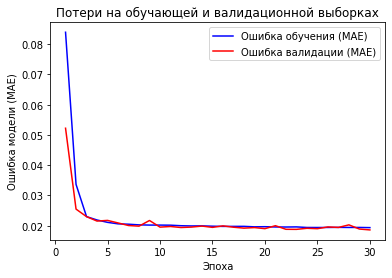

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import r2_score,mean_absolute_error

print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,
                                                     y_pred=y_pred_inv),3))

213/213 [==============================] - 1s 3ms/step
R2 Score (Test) =  0.972
MAE (Test) =  1.029


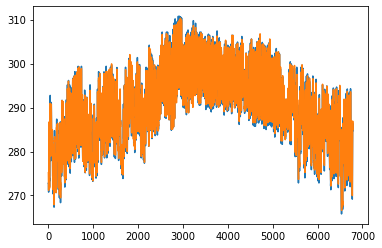

In [ ]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)